# Signature Classification

![img](../images/signature_banner.jpeg)

## Overview

The aim of this analysis is to identify fraudulent signatures in a dataset. My audience here is _______. Using just a small dataset with only 300 sample I was able to create a 

## Business Problem

Currently institutions and businesses recognize signatures as the primary way of authenticating transactions. Signatures are used to sign checks, authorize documents and contracts, and validate credit card transactions. According to recent studies, check fraud costs banks about $900M a year with 22 percent of all fraudulent checks attributed to signature fraud. Therefor, creating an algorithm to identify signature fraud is a valuable asset. 

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #This prevents kernel shut down due to xgboost conflict
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, metrics, regularizers, losses
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc, recall_score, precision_score, \
                            confusion_matrix, plot_confusion_matrix, \
                            roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV 
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import GridSearchCV 

## Colab Necessary Code

Google Colab was used to help streamline the modeling process. Modeling using Convolutional Neural Networks can be computationally expensive, so if you would like to run this notebook faster, I would recommend creating a Colab account and storing the data, discussed below, in a Google Drive file. 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import zipfile

In [ ]:
# pip install unzip
# import unzip
# !unzip /content/drive/MyDrive/signatures.zip 

## Data

The data used in this notebook can be found [here](https://www.kaggle.com/datasets/divyanshrai/handwritten-signatures). The dataset contains just 300 samples of genuine and forged signatures from 30 people, of which 50 percent are genuine and 50 percent are forged. 

In [69]:
# instantiate ImageDataGenerator scaling each pixel's values down to a scale of 1
img = ImageDataGenerator(rescale=1/255)

In [70]:
data_path = '../Data/sample_Signature/sample_Signature/'
# For Colab 
# data_path = '/content/sample_Signature/sample_Signature/'

In [71]:
# Importing the data
data = img.flow_from_directory(data_path, color_mode='grayscale',\
                               batch_size=300, class_mode='binary')

Found 300 images belonging to 2 classes.


In [72]:
data.class_indices

{'forged': 0, 'genuine': 1}

In [73]:
data_images, data_labels = next(data)

In [74]:
data_images.shape

(300, 256, 256, 1)

In [75]:
data_labels.shape

(300,)

In [76]:
X_train, X_test, y_train, y_test = train_test_split( \
            data_images, data_labels, random_state=42, test_size=.2)

In [77]:
X_train.shape

(240, 256, 256, 1)

In [78]:
y_train.shape

(240,)

Above we instantiate Keras' ImageDataGenerator which will scale each pixel's values down to a value of 1. Next we import the data and separate into the images themselves and their respective labels. Finally we split it into a train and test dataset. 

### Image Augmentation

Because we have such a small dataset it is important to use image augmentation to artificially expand the training dataset. Below we do several forms of data augmentation individually before combining the techniques at the end.

#### Zoom Augmentation

The first technique we explore is zoom range. Entering a range of values, .25 and 1 in this case, randomly applies a zoom to each image within that range.

In [79]:
aug = ImageDataGenerator(zoom_range=[.25,1])
aug.fit(X_train)
aug_data = aug.flow(X_train, y_train, batch_size=240)

In [80]:
aug_images, aug_labels = next(aug_data)

In [81]:
aug_images.shape

(192, 256, 256, 1)

In [82]:
aug_labels.shape

(192,)

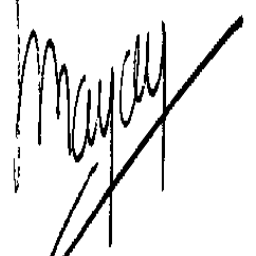

In [83]:
array_to_img(aug_images[0])

In [84]:
new_images1 = np.concatenate([X_train, aug_images])
new_labels1 = np.concatenate([y_train, aug_labels])

In [85]:
new_images1.shape

(432, 256, 256, 1)

In [87]:
new_labels1.shape

(432,)

#### Width Augmentation

The next method for augmentation used was width shift range. With a range of .3 the images will be randomly assigned a width down to .3 of the original image size. 

In [88]:
aug = ImageDataGenerator(width_shift_range=.3)
aug.fit(X_train)
aug2_data = aug.flow(X_train, y_train, batch_size=240)

In [90]:
aug2_images, aug2_labels = next(aug2_data)

In [92]:
new_images2 = np.concatenate([new_images1, aug2_images])
new_labels2 = np.concatenate([new_labels1, aug2_labels])

#### Height Augmentation

The next method for augmentation used was height shift range. With a range of .3 the images will be randomly assigned a height down to .3 of the original image size.

In [94]:
aug = ImageDataGenerator(height_shift_range=.3)
aug.fit(X_train)
aug3_data = aug.flow(X_train, y_train, batch_size=240)

In [95]:
aug3_images, aug3_labels = next(aug3_data)

In [96]:
new_images3 = np.concatenate([new_images2, aug3_images])
new_labels3 = np.concatenate([new_labels2, aug3_labels])

#### Rotation Augmentation

Next we apply a random rotation to each image up to 30 degrees.

In [98]:
aug = ImageDataGenerator(rotation_range=30)
aug.fit(X_train)
aug4_data = aug.flow(X_train, y_train, batch_size=240)

In [99]:
aug4_images, aug4_labels = next(aug4_data)

In [100]:
new_images4 = np.concatenate([new_images3, aug4_images])
new_labels4 = np.concatenate([new_labels3, aug4_labels])

#### Shear Augmentation

We then apply a random shear value to each image. This angles the corners of each image up to 30 degrees.

In [ ]:
aug = ImageDataGenerator(shear_range=30)
aug.fit(X_train)
aug5_data = aug.flow(X_train, y_train, batch_size=240)

In [ ]:
aug5_images, aug5_labels = next(aug5_data)

In [ ]:
new_images5 = np.concatenate([new_images4, aug5_images])
new_labels5 = np.concatenate([new_labels4, aug5_labels])

#### Brightness Augmentation

Finally we have brightness augmentation. This applies a random brightness shift within the provided range. 

In [ ]:
aug = ImageDataGenerator(brightness_range=(1,2))
aug.fit(X_train)
aug5_data = aug.flow(X_train, y_train, batch_size=240)

In [ ]:
aug6_images, aug6_labels = next(aug5_data)

In [ ]:
new_images6 = np.concatenate([new_images5, aug6_images])
new_labels6 = np.concatenate([new_labels5, aug6_labels])

#### A little bit of everything Augmentation

In [104]:
aug = ImageDataGenerator(zoom_range=[.7,.9], width_shift_range=.15, height_shift_range=.15, rotation_range=15, shear_range=15, brightness_range=(1,1.5))
aug.fit(new_images6)
aug_data_final = aug.flow(new_images6, new_labels6, batch_size=1680)

In [105]:
aug_final_images, aug_final_labels = next(aug_data_final)

In [106]:
final_images = np.concatenate([new_images6, aug_final_images])
final_labels = np.concatenate([new_labels6, aug_final_labels])

In [108]:
final_images.shape

(2016, 256, 256, 1)

In [109]:
final_labels.shape

(2016,)

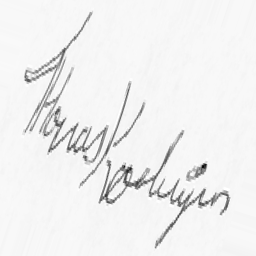

In [110]:
array_to_img(final_images[0])

In [111]:
final_labels[0]

0.0

## Modeling

### Dummy Model

In [112]:
dummy_model = DummyClassifier()
dummy_model.fit(final_images, final_labels)

DummyClassifier()

In [113]:
dummy_preds = dummy_model.predict(X_test)

dummy_acc = dummy_model.score(X_test, y_test)


### CNN Model 1

In [47]:
# model = Sequential()

In [48]:
# model.add(layers.Conv2D(filters=32,
#                        kernel_size=(3,3),
#                        activation='relu',
#                        input_shape=(256,256,1)))

# model.add(layers.MaxPool2D())

# model.add(layers.Conv2D(64, (3,3), activation='relu'))


2022-05-19 12:12:12.866045: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 12:12:12.871518: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [49]:
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [50]:
# model.add(layers.Flatten())
# model.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(l=0.05)))
# model.add(layers.Dropout(.25))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dense(1, activation='tanh'))

In [51]:
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
flatten (Flatten)            (None, 1000000)           0         
_________________________________________________________________
dense (Dense)                (None, 32)                32000032  
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                5

In [61]:
# sgd = SGD(learning_rate=.01)
# adam = Adam(learning_rate=.0001)

In [62]:
# model.compile(optimizer=sgd, \
#               loss='binary_crossentropy', \
#               metrics=['accuracy', 'AUC'],\
#              experimental_run_tf_function=False) 

In [54]:
# model.fit(X_traintrain, y_traintrain, epochs=5, \
#           batch_size=10, validation_data=(X_val, y_val))

In [63]:
# model.fit(final_images, final_labels, epochs=10, \
#           batch_size=10, validation_data=(X_val, y_val))

Train on 1920 samples, validate on 48 samples
Epoch 1/10
1920/1920 [==============================] - 290s 151ms/sample - loss: 3.2742 - accuracy: 0.4974 - AUC: 0.4793 - val_loss: 2.7944 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 2/10
1920/1920 [==============================] - 271s 141ms/sample - loss: 2.4387 - accuracy: 0.5115 - AUC: 0.5104 - val_loss: 2.1245 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 3/10
1920/1920 [==============================] - 261s 136ms/sample - loss: 1.8825 - accuracy: 0.5010 - AUC: 0.5055 - val_loss: 1.6721 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 4/10
1920/1920 [==============================] - 333s 173ms/sample - loss: 1.5042 - accuracy: 0.5073 - AUC: 0.4712 - val_loss: 1.3568 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 5/10
1020/1920 [==============>...............] - ETA: 2:18 - loss: 1.2949 - accuracy: 0.4863 - AUC: 0.4842

KeyboardInterrupt: 

In [ ]:
# test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)

60/60 [==============================] - 5s 91ms/sample - loss: 3.7655 - accuracy: 0.5500 - AUC: 0.6251

In [57]:
# pred = model.predict(X_test[1].reshape(1, 256, 256, 1))

In [58]:
# np.argmax(pred)

0

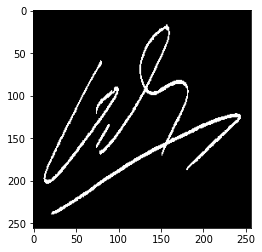

In [59]:
# plt.imshow(X_test[1].reshape(256,256), cmap='Greys')

In [60]:
# y_test[1]

0.0

### Scikit Learn Keras Classifier

In [ ]:
sgd = SGD(learning_rate=.0001)
adam = Adam(learning_rate=.0001)

In [114]:
def build_model():
    model = Sequential()
    model.add(layers.Conv2D(filters=32,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(256,256,1)))

    model.add(layers.MaxPool2D())

    model.add(layers.Conv2D(64, (3,3), activation='relu'))

    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(l=0.05)))
    model.add(layers.Dropout(.25))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [115]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=25,
                                          batch_size=32,
                                          verbose=2)

In [116]:
cross_val_score(keras_model, final_images, final_labels)

Train on 1612 samples
Epoch 1/10


KeyboardInterrupt: 

In [ ]:
keras_model.fit(final_images, final_labels)

In [ ]:
keras_model.score(X_test, y_test)

Adam learning rate = .0001, epochs=25, batch_size=32: loss: 1.0036 - accuracy: 0.7167? Not reproducible when you rerun the cell. 

Adam learning rate = .0001, epochs=50, batch_size=32: loss: 0.8607 - accuracy: 0.6833? Not reproducible when you rerun the cell. 

In [1]:
preds = keras_model.predict(X_test)
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, cmap='Blues')

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = keras_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = round((roc_auc_score(y_test, lr_probs)), 2)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, label=f'Pipeline(AUC = {lr_auc})', color='steelblue')
# show the legend
plt.legend(loc='lower right')

In [ ]:
params = {}

params['batch_size'] = [8,16,32]
params['epochs'] = [10,25,50]

In [ ]:
gs = GridSearchCV(estimator=keras_model, param_grid=params, cv=10)

In [ ]:
gs.fit(final_images, final_labels)

In [ ]:
gs.best_params_, gs.best_score_

## Next Steps

## Conclusion